In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import glob
import sys
from fake_spectra.spectra import Spectra
from scipy.interpolate import interp1d
sys.path.append('../../../py/')

from cosmoSim import cosmoSim

In [2]:
FONT_SIZE = 14

matplotlib.rc('xtick', labelsize=FONT_SIZE)
matplotlib.rc('ytick', labelsize=FONT_SIZE)
matplotlib.rcParams['font.size']=FONT_SIZE

matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rc('text', usetex=True)

ALPHA=0.8

UNIT_HEIGHT = 5

FIG_HEIGHT = UNIT_HEIGHT
FIG_WIDTH = 6 * UNIT_HEIGHT

FIGSIZE=[FIG_WIDTH,FIG_HEIGHT]
DPI=300

snap_range = [5, 4, 3, 2, 1, 0]

zz_color = 'b'
m2m2_color = 'g'
cdm_color = 'r'
zz_dm_color = 'tab:cyan'
m2m2_dm_color = 'tab:olive'
cdm_dm_color = 'tab:pink'

In [3]:
outpath = '../../../plots/plots_L3N256/grid/lyman-spectra/'
base_path = '../../../data_prods'
try:
    os.mkdir(outpath)
except:
    print(f'{outpath} already exists!')


tcDM_DM_runs2 = [ f'run_2cDM_L3N256_DM_powerm2m2_sigma1_dir_{i}' for i in range(10) ]


CDM_runs = [ f'run_CDM_L3N256_HY_dir_{i}' for i in range(10) ] + ['run_CDM_L3N256_HY']

CDM_DM_runs = [ f'run_CDM_L3N256_DM_dir_{i}' for i in range(10) ] + ['run_CDM_L3N256_DM']

tcDM_runs1 = [ f'run_2cDM_L3N256_HY_power00_sigma1_dir_{i}' for i in range(10) ] + ['run_2cDM_L3N256_HY_power00_sigma1']

tcDM_DM_runs1 = [ f'run_2cDM_L3N256_DM_power00_sigma1_dir_{i}' for i in range(10) ] + ['run_2cDM_L3N256_DM_power00_sigma1']

tcDM_runs2 = [ f'run_2cDM_L3N256_HY_powerm2m2_sigma1_dir_{i}' for i in range(10) ] + ['run_2cDM_L3N256_HY_powerm2m2_sigma1']

tcDM_DM_runs2 = [ f'run_2cDM_L3N256_DM_powerm2m2_sigma1_dir_{i}' for i in range(10) ]

../../../plots/plots_L3N256/grid/lyman-spectra/ already exists!


In [4]:
elem = 'H'
ion = 1
line = 1215

In [5]:
def wnumber2wlength(k):
    return 1/k
def wlength2wnumber(l):
    return 1/l    

In [6]:
def get_samples(domain, interpf_list):
    return [ interpf(domain) for interpf in interpf_list ]

def get_dk_averages(run_list, redshift):
    run = cosmoSim(run_list[0], base_path=base_path)
    lims, pk_interp, dk_interp, k_ny =  run.interp_combined_power_spectra(redshift)
    inf = lims[0]
    sup = lims[1]

    interps = []

    for run_n in run_list:
        run = cosmoSim(run_n, base_path=base_path)
        lims, pk_interp, interp, k_ny =  run.interp_combined_power_spectra(redshift)
        interps.append(interp)
        if lims[0] > inf: inf = lims[0]
        if lims[1] < sup: sup = lims[1]

    return (inf, sup), interps

def get_ly_1D_averages(run_list, redshift):
    run = cosmoSim(run_list[0], base_path=base_path)

    num, base = run.get_fake_spectra_savefile_path(redshift)

    sp = Spectra(num=num, base=base, cofm=None, axis=None, savefile="rand_spectra_DLA.hdf5")
    kv, Pk = sp.get_flux_power_1D(elem, ion, line)
    inf = np.amin(kv)
    sup = np.amax(kv)
    
    interps = []
    
    for run_n in run_list:
        
        run = cosmoSim(run_n, base_path=base_path)
        num, base = run.get_fake_spectra_savefile_path(redshift)
        sp = Spectra(num=num, base=base, cofm=None, axis=None, savefile="rand_spectra_DLA.hdf5")
        kv, Pk = sp.get_flux_power_1D(elem, ion, line)
        lims = [np.amin(kv), np.amax(kv)]
        
        if lims[0] > inf: inf = lims[0]
        if lims[1] < sup: sup = lims[1]
        
        interps.append(interp1d(kv, Pk))
    
    return (inf, sup), interps

def get_hmf_averages(run_list, redshift):
    run = cosmoSim(run_list[0], base_path=base_path)
    lims, interp =  run.interp_mass_profile(redshift)
    inf = lims[0]
    sup = lims[1]

    interps = []

    for run_n in run_list:
        run = cosmoSim(run_n, base_path=base_path)
        lims, interp =  run.interp_mass_profile(redshift)
        interps.append(interp)
        if lims[0] > inf: inf = lims[0]
        if lims[1] < sup: sup = lims[1]

    return (inf, sup), interps

def get_cvf_averages(run_list, redshift):
    run = cosmoSim(run_list[0], base_path=base_path)
    lims, interp =  run.interp_vels_profile(redshift)
    inf = lims[0]
    sup = lims[1]

    interps = []

    for run_n in run_list:
        run = cosmoSim(run_n, base_path=base_path)
        lims, interp =  run.interp_vels_profile(redshift)
        interps.append(interp)
        if lims[0] > inf: inf = lims[0]
        if lims[1] < sup: sup = lims[1]

    return (inf, sup), interps

def calculate_averages(domain, interps):
    samps = get_samples(domain, interps)
    avg = np.mean(samps, axis=0)
    ten = np.percentile(samps, 10, axis=0)
    ninety = np.percentile(samps, 90, axis=0)

    return avg, ten, ninety

def calculate_ratios(domain, interps_numerator, interps_denominator):
    samps_numerator = get_samples(domain, interps_numerator)
    samps_denominator = get_samples(domain, interps_denominator)

    samps = [ num / den for num, den in zip(samps_numerator, samps_denominator) ]
    avg = np.mean(samps, axis=0)
    ten = np.percentile(samps, 10, axis=0)
    ninety = np.percentile(samps, 90, axis=0)

    return avg, ten, ninety


def get_averages(CDM_runs, tcDM_runs, redshift, function='dk', ratios=False):

    if function == 'dk':
        get_avg_func = get_dk_averages
    elif function == 'mass':
        get_avg_func = get_hmf_averages
    elif function == 'velocity':
        get_avg_func = get_cvf_averages
    elif function == 'ly-1D':
        get_avg_func = get_ly_1D_averages

    clims, CDM_interps = get_avg_func(CDM_runs, redshift)
    tlims, tcDM_interps = get_avg_func(tcDM_runs, redshift)

    inf = clims[0] if clims[0] > tlims[0] else tlims[0]
    sup = clims[1] if clims[1] < tlims[1] else tlims[1]

    domain = np.geomspace(inf, sup, num=1000)

    if ratios:
        ratio_samps, ratios_ten, ratios_ninety = calculate_ratios(domain, tcDM_interps, CDM_interps)
        return domain, (ratio_samps, ratios_ten, ratios_ninety)
    else:
        CDM_avg, CDM_ten, CDM_ninety = calculate_averages(domain, CDM_interps)
        tcDM_avg, tcDM_ten, tcDM_ninety = calculate_averages(domain, tcDM_interps)

        return domain, (CDM_avg, CDM_ten, CDM_ninety), (tcDM_avg, tcDM_ten, tcDM_ninety)

Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_CDM_L3N256_HY_dir_0/SPECTRA_002/rand_spectra_DLA.hdf5  )


1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_CDM_L3N256_HY_dir_0/SPECTRA_002/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_CDM_L3N256_HY_dir_1/SPECTRA_002/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_CDM_L3N256_HY_dir_2/SPECTRA_002/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_CDM_L3N256_HY_dir_3/SPECTRA_002/rand_spectra_DLA.hdf5  )


<>:51: SyntaxWarning: invalid escape sequence '\p'
<>:51: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_3649323/1477717242.py:51: SyntaxWarning: invalid escape sequence '\p'
  ax[0].set_ylabel('k $P_{F}(k) / \pi$')
/home/ryan/projects/Medvedev/dm_sims/jupyter/global/paperI/../../../py/cosmoSim.py:118: UserWarning: WARNING: Requested redshift 5 is not within tolerance 0.1 of snapshot redshift 5.236226422509304 in run run_CDM_L3N256_HY_dir_0!
  warnings.warn(f"WARNING: Requested redshift {redshift} is not within tolerance {tolerance} of snapshot redshift {self.redshifts[idx]} in run {self.run_name}!")
/home/ryan/projects/Medvedev/dm_sims/jupyter/global/paperI/../../../py/cosmoSim.py:118: UserWarning: WARNING: Requested redshift 5 is not within tolerance 0.1 of snapshot redshift 5.236226422509304 in run run_CDM_L3N256_HY_dir_1!
  warnings.warn(f"WARNING: Requested redshift {redshift} is not within tolerance {tolerance} of snapshot redshift {self.redshifts[idx]} in run {self.r

1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_CDM_L3N256_HY_dir_4/SPECTRA_002/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_CDM_L3N256_HY_dir_5/SPECTRA_002/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_CDM_L3N256_HY_dir_6/SPECTRA_002/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_CDM_L3N256_HY_dir_7/SPECTRA_002/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from file /hom

/home/ryan/projects/Medvedev/dm_sims/jupyter/global/paperI/../../../py/cosmoSim.py:118: UserWarning: WARNING: Requested redshift 5 is not within tolerance 0.1 of snapshot redshift 5.236226422509304 in run run_CDM_L3N256_HY_dir_4!
  warnings.warn(f"WARNING: Requested redshift {redshift} is not within tolerance {tolerance} of snapshot redshift {self.redshifts[idx]} in run {self.run_name}!")
/home/ryan/projects/Medvedev/dm_sims/jupyter/global/paperI/../../../py/cosmoSim.py:118: UserWarning: WARNING: Requested redshift 5 is not within tolerance 0.1 of snapshot redshift 5.236226422509304 in run run_CDM_L3N256_HY_dir_5!
  warnings.warn(f"WARNING: Requested redshift {redshift} is not within tolerance {tolerance} of snapshot redshift {self.redshifts[idx]} in run {self.run_name}!")
/home/ryan/projects/Medvedev/dm_sims/jupyter/global/paperI/../../../py/cosmoSim.py:118: UserWarning: WARNING: Requested redshift 5 is not within tolerance 0.1 of snapshot redshift 5.236226422509304 in run run_CDM_L3N

1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_2cDM_L3N256_HY_power00_sigma1_dir_0/SPECTRA_002/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_2cDM_L3N256_HY_power00_sigma1_dir_0/SPECTRA_002/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_2cDM_L3N256_HY_power00_sigma1_dir_1/SPECTRA_002/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_2cDM_L3N256_HY_power00_sigma1_dir_2/SPECTRA_002/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.0011307542673908  z

/home/ryan/projects/Medvedev/dm_sims/jupyter/global/paperI/../../../py/cosmoSim.py:118: UserWarning: WARNING: Requested redshift 5 is not within tolerance 0.1 of snapshot redshift 5.236226422509304 in run run_2cDM_L3N256_HY_power00_sigma1_dir_0!
  warnings.warn(f"WARNING: Requested redshift {redshift} is not within tolerance {tolerance} of snapshot redshift {self.redshifts[idx]} in run {self.run_name}!")
/home/ryan/projects/Medvedev/dm_sims/jupyter/global/paperI/../../../py/cosmoSim.py:118: UserWarning: WARNING: Requested redshift 5 is not within tolerance 0.1 of snapshot redshift 5.236226422509304 in run run_2cDM_L3N256_HY_power00_sigma1_dir_1!
  warnings.warn(f"WARNING: Requested redshift {redshift} is not within tolerance {tolerance} of snapshot redshift {self.redshifts[idx]} in run {self.run_name}!")
/home/ryan/projects/Medvedev/dm_sims/jupyter/global/paperI/../../../py/cosmoSim.py:118: UserWarning: WARNING: Requested redshift 5 is not within tolerance 0.1 of snapshot redshift 5.23

1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_2cDM_L3N256_HY_power00_sigma1_dir_7/SPECTRA_002/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_2cDM_L3N256_HY_power00_sigma1_dir_8/SPECTRA_002/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_2cDM_L3N256_HY_power00_sigma1_dir_9/SPECTRA_002/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_2cDM_L3N256_HY_power00_sigma1/SPECTRA_002/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.0011307542673908  z= 5.23

/home/ryan/projects/Medvedev/dm_sims/jupyter/global/paperI/../../../py/cosmoSim.py:118: UserWarning: WARNING: Requested redshift 5 is not within tolerance 0.1 of snapshot redshift 5.236226422509304 in run run_2cDM_L3N256_HY_power00_sigma1_dir_7!
  warnings.warn(f"WARNING: Requested redshift {redshift} is not within tolerance {tolerance} of snapshot redshift {self.redshifts[idx]} in run {self.run_name}!")
/home/ryan/projects/Medvedev/dm_sims/jupyter/global/paperI/../../../py/cosmoSim.py:118: UserWarning: WARNING: Requested redshift 5 is not within tolerance 0.1 of snapshot redshift 5.236226422509304 in run run_2cDM_L3N256_HY_power00_sigma1_dir_8!
  warnings.warn(f"WARNING: Requested redshift {redshift} is not within tolerance {tolerance} of snapshot redshift {self.redshifts[idx]} in run {self.run_name}!")
/home/ryan/projects/Medvedev/dm_sims/jupyter/global/paperI/../../../py/cosmoSim.py:118: UserWarning: WARNING: Requested redshift 5 is not within tolerance 0.1 of snapshot redshift 5.23

1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_CDM_L3N256_HY_dir_3/SPECTRA_002/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_CDM_L3N256_HY_dir_4/SPECTRA_002/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_CDM_L3N256_HY_dir_5/SPECTRA_002/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_CDM_L3N256_HY_dir_6/SPECTRA_002/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from file /hom

/home/ryan/projects/Medvedev/dm_sims/jupyter/global/paperI/../../../py/cosmoSim.py:118: UserWarning: WARNING: Requested redshift 5 is not within tolerance 0.1 of snapshot redshift 5.236226422509304 in run run_2cDM_L3N256_HY_powerm2m2_sigma1_dir_0!
  warnings.warn(f"WARNING: Requested redshift {redshift} is not within tolerance {tolerance} of snapshot redshift {self.redshifts[idx]} in run {self.run_name}!")
/home/ryan/projects/Medvedev/dm_sims/jupyter/global/paperI/../../../py/cosmoSim.py:118: UserWarning: WARNING: Requested redshift 5 is not within tolerance 0.1 of snapshot redshift 5.236226422509304 in run run_2cDM_L3N256_HY_powerm2m2_sigma1_dir_1!
  warnings.warn(f"WARNING: Requested redshift {redshift} is not within tolerance {tolerance} of snapshot redshift {self.redshifts[idx]} in run {self.run_name}!")
/home/ryan/projects/Medvedev/dm_sims/jupyter/global/paperI/../../../py/cosmoSim.py:118: UserWarning: WARNING: Requested redshift 5 is not within tolerance 0.1 of snapshot redshift 

1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_2cDM_L3N256_HY_powerm2m2_sigma1_dir_7/SPECTRA_002/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_2cDM_L3N256_HY_powerm2m2_sigma1_dir_8/SPECTRA_002/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_2cDM_L3N256_HY_powerm2m2_sigma1_dir_9/SPECTRA_002/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_2cDM_L3N256_HY_powerm2m2_sigma1/SPECTRA_002/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.0011307542673908 

/home/ryan/projects/Medvedev/dm_sims/jupyter/global/paperI/../../../py/cosmoSim.py:118: UserWarning: WARNING: Requested redshift 5 is not within tolerance 0.1 of snapshot redshift 5.236226422509304 in run run_2cDM_L3N256_HY_powerm2m2_sigma1_dir_7!
  warnings.warn(f"WARNING: Requested redshift {redshift} is not within tolerance {tolerance} of snapshot redshift {self.redshifts[idx]} in run {self.run_name}!")
/home/ryan/projects/Medvedev/dm_sims/jupyter/global/paperI/../../../py/cosmoSim.py:118: UserWarning: WARNING: Requested redshift 5 is not within tolerance 0.1 of snapshot redshift 5.236226422509304 in run run_2cDM_L3N256_HY_powerm2m2_sigma1_dir_8!
  warnings.warn(f"WARNING: Requested redshift {redshift} is not within tolerance {tolerance} of snapshot redshift {self.redshifts[idx]} in run {self.run_name}!")
/home/ryan/projects/Medvedev/dm_sims/jupyter/global/paperI/../../../py/cosmoSim.py:118: UserWarning: WARNING: Requested redshift 5 is not within tolerance 0.1 of snapshot redshift 

1000  sightlines. resolution:  1.001540269290691  z= 3.9916277163626868
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_CDM_L3N256_HY_dir_1/SPECTRA_003/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.001540269290691  z= 3.9916277163626868
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_CDM_L3N256_HY_dir_2/SPECTRA_003/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.001540269290691  z= 3.9916277163626868
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_CDM_L3N256_HY_dir_3/SPECTRA_003/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.0020726252065086  z= 3.997243005033612
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_CDM_L3N256_HY_dir_4/SPECTRA_003/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.0020726252065086  z= 3.997243005033612
Reading pre-computed spectra (from file /hom

/tmp/ipykernel_3649323/2174059925.py:4: RuntimeWarning: divide by zero encountered in divide
  return 1/l
/tmp/ipykernel_3649323/2174059925.py:4: RuntimeWarning: divide by zero encountered in divide
  return 1/l
/tmp/ipykernel_3649323/2174059925.py:4: RuntimeWarning: divide by zero encountered in divide
  return 1/l
/tmp/ipykernel_3649323/2174059925.py:4: RuntimeWarning: divide by zero encountered in divide
  return 1/l


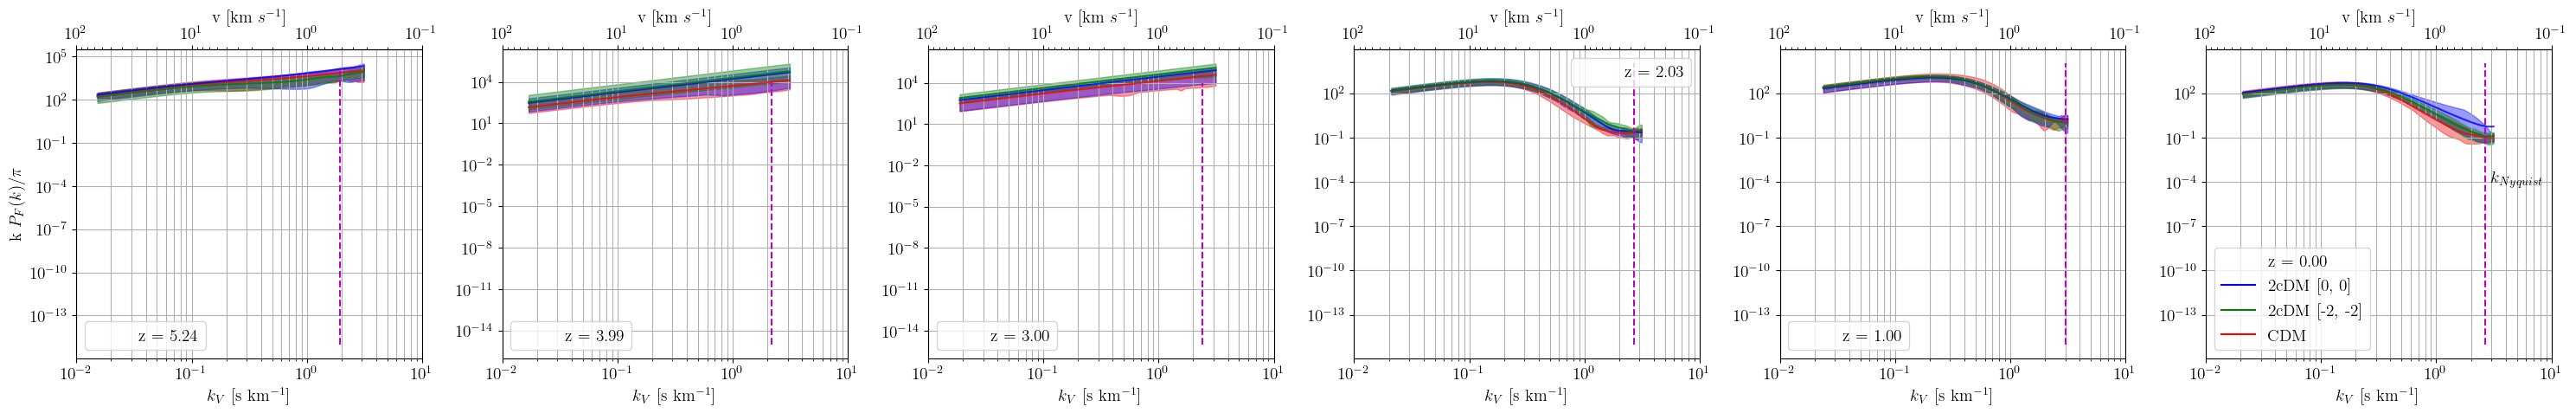

In [9]:
fig, ax = plt.subplots(1, len(snap_range), figsize=FIGSIZE)

for a, redshift in zip(ax, snap_range):

    tcDM_runs = tcDM_runs1

    bins, (CDM_avg, CDM_ten, CDM_ninety), (tcDM_avg, tcDM_ten, tcDM_ninety) = get_averages(CDM_runs, tcDM_runs, redshift, function='ly-1D')
    a.plot(bins, bins / np.pi * CDM_avg, alpha=ALPHA, color=cdm_color)
    a.fill_between(bins, bins / np.pi * CDM_ten, bins / np.pi * CDM_ninety, alpha=0.5*ALPHA, color=cdm_color)

    a.plot(bins, bins / np.pi * tcDM_avg, alpha=ALPHA, color=zz_color)
    a.fill_between(bins, bins / np.pi * tcDM_ten, bins / np.pi * tcDM_ninety, alpha=0.5*ALPHA, color=zz_color)

    tcDM_runs = tcDM_runs2
    try:
        bins, _, (tcDM_avg, tcDM_ten, tcDM_ninety) = get_averages(CDM_runs, tcDM_runs, redshift, function='ly-1D')
        a.plot(bins, bins / np.pi * tcDM_avg, alpha=ALPHA, color=m2m2_color)
        a.fill_between(bins, bins / np.pi * tcDM_ten, bins / np.pi * tcDM_ninety, alpha=0.5*ALPHA, color=m2m2_color)
    except:
        pass

    # calculate nyquist k
    run = cosmoSim(tcDM_runs[0], base_path=base_path)
    num, base = run.get_fake_spectra_savefile_path(redshift)
    sp = Spectra(num=num, base=base, cofm=None, axis=None, savefile="rand_spectra_DLA.hdf5")
    vmax = sp.vmax # km/s
    box_size_Mpc = run.boxsize / 1000 # Mpc
    velfac = vmax / box_size_Mpc # km/s/Mpc
    k_ny_invMpc = run.load_power_spectra(redshift)[-1]
    k_ny = k_ny_invMpc / velfac
    
    
    a.vlines(k_ny, 10**-15, 10**4, colors='m', linestyles='dashed')
    r_nearest = cosmoSim(CDM_runs[0], base_path=base_path).get_nearest_redshift(redshift)

    a.set_xlabel('$k_V$ [s km$^{-1}$]')


    a.set_yscale("log")
    a.set_xscale("log")
    a.set_xlim(10**-2, 10**1)
    #a.set_ylim(10**-8, 10**1)
    a.grid(True, which="both", ls="-")
    a.set_aspect( 'auto', adjustable='box' )
    a.plot([],[], label=f'z = {r_nearest:.2f}', alpha=0)
    a.legend()
    
    sax = a.secondary_xaxis('top', functions=(wnumber2wlength, wlength2wnumber))
    sax.set_xlabel('v [km $s^{-1}$]')
    
ax[0].set_ylabel('k $P_{F}(k) / \pi$')

#a.set_ylim(10**-13, 10**1)

a.plot([],[], label='2cDM [0, 0]', color=zz_color)
a.plot([],[], label='2cDM [-2, -2]', color=m2m2_color)
a.plot([],[], label='CDM', color=cdm_color)
a.text(3, 10**-4, '$k_{Nyquist}$')
# a.plot([],[], label='Hydro', color='k')
# a.plot([],[], label='N-Body', color='k', linestyle='dashed')
a.legend()

fig.tight_layout()
fname = outpath + f'grid_ly_1D'
fname += '_with00'
fname += '_withm2m2'
fname += '.pdf'
plt.savefig(fname, dpi=DPI, bbox_inches='tight')
plt.show()

Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_CDM_L3N256_HY_dir_0/SPECTRA_002/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_CDM_L3N256_HY_dir_0/SPECTRA_002/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_CDM_L3N256_HY_dir_1/SPECTRA_002/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_CDM_L3N256_HY_dir_2/SPECTRA_002/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_CDM_L3N256_HY_dir_3/SPEC

/home/ryan/projects/Medvedev/dm_sims/jupyter/global/paperI/../../../py/cosmoSim.py:118: UserWarning: WARNING: Requested redshift 5 is not within tolerance 0.1 of snapshot redshift 5.236226422509304 in run run_CDM_L3N256_HY_dir_0!
  warnings.warn(f"WARNING: Requested redshift {redshift} is not within tolerance {tolerance} of snapshot redshift {self.redshifts[idx]} in run {self.run_name}!")
/home/ryan/projects/Medvedev/dm_sims/jupyter/global/paperI/../../../py/cosmoSim.py:118: UserWarning: WARNING: Requested redshift 5 is not within tolerance 0.1 of snapshot redshift 5.236226422509304 in run run_CDM_L3N256_HY_dir_1!
  warnings.warn(f"WARNING: Requested redshift {redshift} is not within tolerance {tolerance} of snapshot redshift {self.redshifts[idx]} in run {self.run_name}!")
/home/ryan/projects/Medvedev/dm_sims/jupyter/global/paperI/../../../py/cosmoSim.py:118: UserWarning: WARNING: Requested redshift 5 is not within tolerance 0.1 of snapshot redshift 5.236226422509304 in run run_CDM_L3N

1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_CDM_L3N256_HY_dir_7/SPECTRA_002/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_CDM_L3N256_HY_dir_8/SPECTRA_002/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_CDM_L3N256_HY_dir_9/SPECTRA_002/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_CDM_L3N256_HY/SPECTRA_002/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from file /home/ryan

/home/ryan/projects/Medvedev/dm_sims/jupyter/global/paperI/../../../py/cosmoSim.py:118: UserWarning: WARNING: Requested redshift 5 is not within tolerance 0.1 of snapshot redshift 5.236226422509304 in run run_CDM_L3N256_HY_dir_7!
  warnings.warn(f"WARNING: Requested redshift {redshift} is not within tolerance {tolerance} of snapshot redshift {self.redshifts[idx]} in run {self.run_name}!")
/home/ryan/projects/Medvedev/dm_sims/jupyter/global/paperI/../../../py/cosmoSim.py:118: UserWarning: WARNING: Requested redshift 5 is not within tolerance 0.1 of snapshot redshift 5.236226422509304 in run run_CDM_L3N256_HY_dir_8!
  warnings.warn(f"WARNING: Requested redshift {redshift} is not within tolerance {tolerance} of snapshot redshift {self.redshifts[idx]} in run {self.run_name}!")
/home/ryan/projects/Medvedev/dm_sims/jupyter/global/paperI/../../../py/cosmoSim.py:118: UserWarning: WARNING: Requested redshift 5 is not within tolerance 0.1 of snapshot redshift 5.236226422509304 in run run_CDM_L3N

1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_2cDM_L3N256_HY_power00_sigma1_dir_3/SPECTRA_002/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_2cDM_L3N256_HY_power00_sigma1_dir_4/SPECTRA_002/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_2cDM_L3N256_HY_power00_sigma1_dir_5/SPECTRA_002/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_2cDM_L3N256_HY_power00_sigma1_dir_6/SPECTRA_002/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.0011307542673908  z

/home/ryan/projects/Medvedev/dm_sims/jupyter/global/paperI/../../../py/cosmoSim.py:118: UserWarning: WARNING: Requested redshift 5 is not within tolerance 0.1 of snapshot redshift 5.236226422509304 in run run_2cDM_L3N256_HY_power00_sigma1_dir_3!
  warnings.warn(f"WARNING: Requested redshift {redshift} is not within tolerance {tolerance} of snapshot redshift {self.redshifts[idx]} in run {self.run_name}!")
/home/ryan/projects/Medvedev/dm_sims/jupyter/global/paperI/../../../py/cosmoSim.py:118: UserWarning: WARNING: Requested redshift 5 is not within tolerance 0.1 of snapshot redshift 5.236226422509304 in run run_2cDM_L3N256_HY_power00_sigma1_dir_4!
  warnings.warn(f"WARNING: Requested redshift {redshift} is not within tolerance {tolerance} of snapshot redshift {self.redshifts[idx]} in run {self.run_name}!")
/home/ryan/projects/Medvedev/dm_sims/jupyter/global/paperI/../../../py/cosmoSim.py:118: UserWarning: WARNING: Requested redshift 5 is not within tolerance 0.1 of snapshot redshift 5.23

1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_2cDM_L3N256_HY_power00_sigma1/SPECTRA_002/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_CDM_L3N256_HY_dir_0/SPECTRA_002/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_CDM_L3N256_HY_dir_0/SPECTRA_002/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_CDM_L3N256_HY_dir_1/SPECTRA_002/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from

/home/ryan/projects/Medvedev/dm_sims/jupyter/global/paperI/../../../py/cosmoSim.py:118: UserWarning: WARNING: Requested redshift 5 is not within tolerance 0.1 of snapshot redshift 5.236226422509304 in run run_2cDM_L3N256_HY_power00_sigma1!
  warnings.warn(f"WARNING: Requested redshift {redshift} is not within tolerance {tolerance} of snapshot redshift {self.redshifts[idx]} in run {self.run_name}!")


1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_CDM_L3N256_HY_dir_6/SPECTRA_002/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_CDM_L3N256_HY_dir_7/SPECTRA_002/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_CDM_L3N256_HY_dir_8/SPECTRA_002/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_CDM_L3N256_HY_dir_9/SPECTRA_002/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from file /hom

/home/ryan/projects/Medvedev/dm_sims/jupyter/global/paperI/../../../py/cosmoSim.py:118: UserWarning: WARNING: Requested redshift 5 is not within tolerance 0.1 of snapshot redshift 5.236226422509304 in run run_2cDM_L3N256_HY_powerm2m2_sigma1_dir_0!
  warnings.warn(f"WARNING: Requested redshift {redshift} is not within tolerance {tolerance} of snapshot redshift {self.redshifts[idx]} in run {self.run_name}!")
/home/ryan/projects/Medvedev/dm_sims/jupyter/global/paperI/../../../py/cosmoSim.py:118: UserWarning: WARNING: Requested redshift 5 is not within tolerance 0.1 of snapshot redshift 5.236226422509304 in run run_2cDM_L3N256_HY_powerm2m2_sigma1_dir_1!
  warnings.warn(f"WARNING: Requested redshift {redshift} is not within tolerance {tolerance} of snapshot redshift {self.redshifts[idx]} in run {self.run_name}!")
/home/ryan/projects/Medvedev/dm_sims/jupyter/global/paperI/../../../py/cosmoSim.py:118: UserWarning: WARNING: Requested redshift 5 is not within tolerance 0.1 of snapshot redshift 

1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_2cDM_L3N256_HY_powerm2m2_sigma1_dir_7/SPECTRA_002/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_2cDM_L3N256_HY_powerm2m2_sigma1_dir_8/SPECTRA_002/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_2cDM_L3N256_HY_powerm2m2_sigma1_dir_9/SPECTRA_002/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.0011307542673908  z= 5.236226422509304
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_2cDM_L3N256_HY_powerm2m2_sigma1/SPECTRA_002/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.0011307542673908 

/home/ryan/projects/Medvedev/dm_sims/jupyter/global/paperI/../../../py/cosmoSim.py:118: UserWarning: WARNING: Requested redshift 5 is not within tolerance 0.1 of snapshot redshift 5.236226422509304 in run run_2cDM_L3N256_HY_powerm2m2_sigma1_dir_7!
  warnings.warn(f"WARNING: Requested redshift {redshift} is not within tolerance {tolerance} of snapshot redshift {self.redshifts[idx]} in run {self.run_name}!")
/home/ryan/projects/Medvedev/dm_sims/jupyter/global/paperI/../../../py/cosmoSim.py:118: UserWarning: WARNING: Requested redshift 5 is not within tolerance 0.1 of snapshot redshift 5.236226422509304 in run run_2cDM_L3N256_HY_powerm2m2_sigma1_dir_8!
  warnings.warn(f"WARNING: Requested redshift {redshift} is not within tolerance {tolerance} of snapshot redshift {self.redshifts[idx]} in run {self.run_name}!")
/home/ryan/projects/Medvedev/dm_sims/jupyter/global/paperI/../../../py/cosmoSim.py:118: UserWarning: WARNING: Requested redshift 5 is not within tolerance 0.1 of snapshot redshift 

1000  sightlines. resolution:  1.001540269290691  z= 3.9916277163626868
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_CDM_L3N256_HY_dir_2/SPECTRA_003/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.001540269290691  z= 3.9916277163626868
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_CDM_L3N256_HY_dir_3/SPECTRA_003/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.0020726252065086  z= 3.997243005033612
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_CDM_L3N256_HY_dir_4/SPECTRA_003/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.0020726252065086  z= 3.997243005033612
Reading pre-computed spectra (from file /home/ryan/projects/Medvedev/dm_sims/data_prods/run_CDM_L3N256_HY_dir_5/SPECTRA_003/rand_spectra_DLA.hdf5  )
1000  sightlines. resolution:  1.001540269290691  z= 3.9916277163626868
Reading pre-computed spectra (from file /hom

/tmp/ipykernel_3649323/2174059925.py:4: RuntimeWarning: divide by zero encountered in divide
  return 1/l
/tmp/ipykernel_3649323/2174059925.py:4: RuntimeWarning: divide by zero encountered in divide
  return 1/l
/tmp/ipykernel_3649323/2174059925.py:4: RuntimeWarning: divide by zero encountered in divide
  return 1/l
/tmp/ipykernel_3649323/2174059925.py:4: RuntimeWarning: divide by zero encountered in divide
  return 1/l
/tmp/ipykernel_3649323/2174059925.py:4: RuntimeWarning: divide by zero encountered in divide
  return 1/l


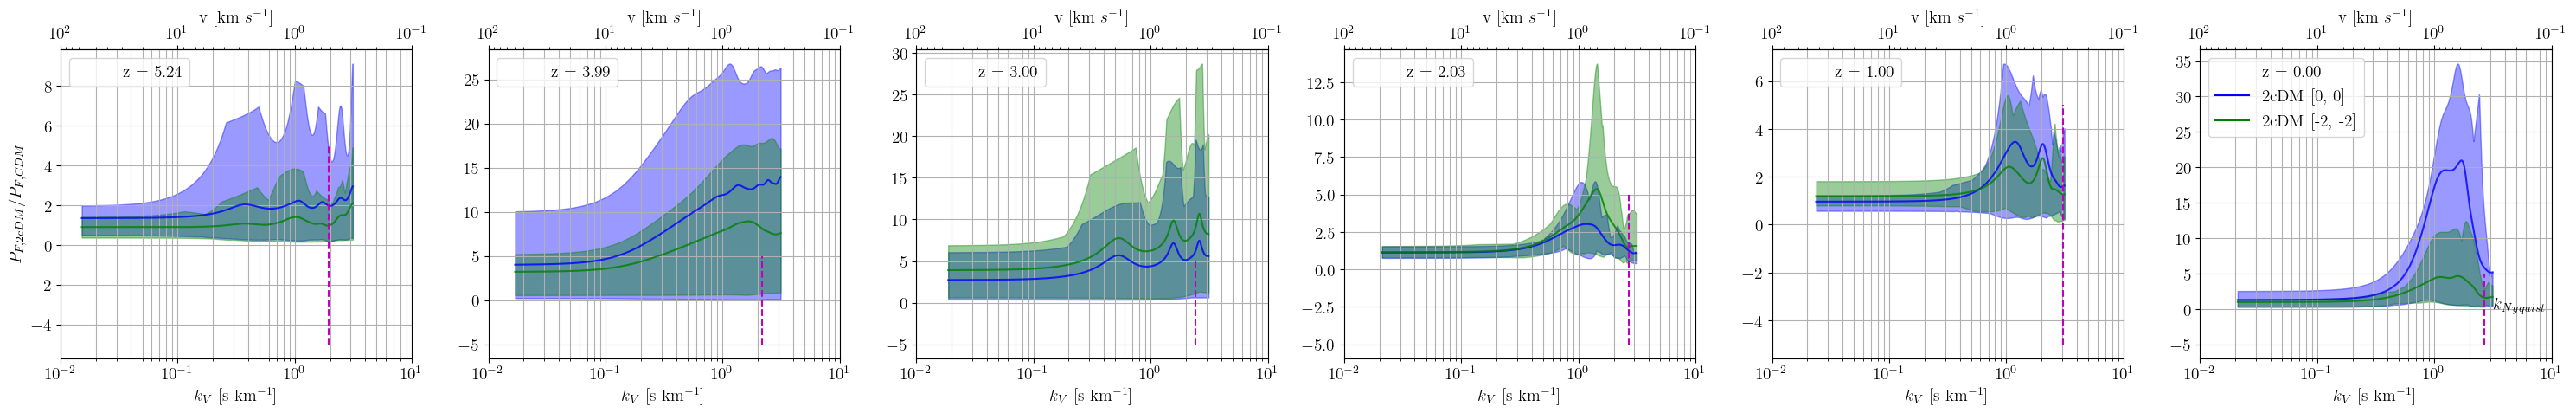

In [8]:
fig, ax = plt.subplots(1, len(snap_range), figsize=FIGSIZE)

for a, redshift in zip(ax, snap_range):

    tcDM_runs = tcDM_runs1

    bins, (ratio_avg, ratio_ten, ratio_ninety) = get_averages(CDM_runs, tcDM_runs, redshift, function='ly-1D', ratios=True)

    a.plot(bins, ratio_avg, alpha=ALPHA, color=zz_color)
    a.fill_between(bins, ratio_ten, ratio_ninety, alpha=0.5*ALPHA, color=zz_color)

    tcDM_runs = tcDM_runs2

    try:
        bins, (ratio_avg, ratio_ten, ratio_ninety) = get_averages(CDM_runs, tcDM_runs, redshift, function='ly-1D', ratios=True)
        a.plot(bins, ratio_avg, alpha=ALPHA, color=m2m2_color)
        a.fill_between(bins, ratio_ten, ratio_ninety, alpha=0.5*ALPHA, color=m2m2_color)
    except:
        pass

    # calculate nyquist k
    run = cosmoSim(tcDM_runs[0], base_path=base_path)
    num, base = run.get_fake_spectra_savefile_path(redshift)
    sp = Spectra(num=num, base=base, cofm=None, axis=None, savefile="rand_spectra_DLA.hdf5")
    vmax = sp.vmax # km/s
    box_size_Mpc = run.boxsize / 1000 # Mpc
    velfac = vmax / box_size_Mpc # km/s/Mpc
    k_ny_invMpc = run.load_power_spectra(redshift)[-1]
    k_ny = k_ny_invMpc / velfac
    
    
    a.vlines(k_ny, -5, 5, colors='m', linestyles='dashed')
    r_nearest = cosmoSim(CDM_runs[0], base_path=base_path).get_nearest_redshift(redshift)

    a.set_xlabel('$k_V$ [s km$^{-1}$]')


    #a.set_yscale("log")
    a.set_xscale("log")
    a.set_xlim(10**-2, 10**1)
    #a.set_ylim(0, 2)
    a.grid(True, which="both", ls="-")
    a.set_aspect( 'auto', adjustable='box' )
    a.plot([],[], label=f'z = {r_nearest:.2f}', alpha=0)
    a.legend()
    
    sax = a.secondary_xaxis('top', functions=(wnumber2wlength, wlength2wnumber))
    sax.set_xlabel('v [km $s^{-1}$]')
    
ax[0].set_ylabel('$P_{F,2cDM}/P_{F,CDM}$')

a.plot([],[], label='2cDM [0, 0]', color=zz_color)
a.plot([],[], label='2cDM [-2, -2]', color=m2m2_color)
# a.plot([],[], label='CDM', color=cdm_color)
a.text(3.2, 0.1, '$k_{Nyquist}$')
# a.plot([],[], label='Hydro', color='k')
# a.plot([],[], label='N-Body', color='k', linestyle='dashed')
a.legend()

fig.tight_layout()
fname = outpath + f'grid_ly_1D_ratio'
fname += '_with00'
fname += '_withm2m2'
fname += '.pdf'
plt.savefig(fname, dpi=DPI, bbox_inches='tight')
plt.show()